In [6]:
from floppity import Retrieval, helpers
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=16)
import torch
# from corner import corner
from tqdm import trange
from floppity.simulators import read_ARCiS_input, ARCiS, mock_simulator

### Create simulator (function that takes parameters and returns spectra)

In [3]:
def simulator(obs, pars, thread=0):
    def gaussian(x, centers, sigmas, amplitudes):
        """Add multiple Gaussian features.

        Args:
            x (np.ndarray): Input x-axis (e.g., wavelengths).
            centers (list): List of Gaussian centers.
            sigmas (list): List of Gaussian standard deviations.
            amplitudes (list): List of Gaussian amplitudes.

        Returns:
            np.ndarray: Sum of all Gaussian features evaluated at x.
        """
        y = np.ones_like(x)
        for c, s, a in zip(centers, sigmas, amplitudes):
            y -= a * np.exp(-0.5 * ((x - c) / (s)) ** 2)
        return y

    c=pars[:,0:3]
    s=pars[:,3:6]
    a=pars[:,6:9]
    
    x = {}
    for key in obs.keys():
        wvl = obs[key][:,0]
        x[key] = np.empty([len(c), len(wvl)])
        for i in trange(len(c)):
            x[key][i]=gaussian(wvl, c[i], s[i], a[i])
    return x

### Setup retrieval

In [18]:
R = Retrieval(mock_simulator)

### Get observation
R.get_obs(['/Users/floppityflappity/Work/FlopPITy/src/floppity/data/obs_RV_1.txt', 
            '/Users/floppityflappity/Work/FlopPITy/src/floppity/data/obs_RV_2.txt'])

### Add parameters
R.add_parameter('center1', 1, 5)
R.add_parameter('center2', 4, 8)
R.add_parameter('center3', 8, 12)
R.add_parameter('sigma1', 0.1, 0.7)
R.add_parameter('sigma2', 0.1, 0.7)
R.add_parameter('sigma3', 0.1, 0.7)
R.add_parameter('amplitude1', 0, 1)
R.add_parameter('amplitude2', 0, 1)
R.add_parameter('amplitude3', 0, 1)
R.add_parameter('RV', 0, 10000, post_process=True)
R.add_parameter('offset', -0.1, 0.1, post_process=True)

In [19]:
training_kwargs= dict(
    stop_after_epochs = 5,
    num_atoms = 20,
    learning_rate=5e-4
)

flow_kwargs=dict(
    flow='nsf',
    bins=4,
    transforms=10,
    blocks=2,
    hidden=32,
    dropout=0.25
)

### Run retrieval

In [20]:
R.run(flow_kwargs=flow_kwargs, resume=False, n_threads=2, training_kwargs=training_kwargs, n_rounds=10, n_samples=10)

Starting training...
Round 1
 Neural network successfully converged after 9 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 9
        Best validation performance: 3.6659
        -------------------------
        
Round 2


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_7918qdo__j/croot/libtorch_1744403106694/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2196.)
  outputs, _ = torch.triangular_solve(


Using SNPE-C with atomic loss
 Neural network successfully converged after 7 epochs.
        -------------------------
        ||||| ROUND 2 STATS |||||:
        -------------------------
        Epochs trained: 7
        Best validation performance: 3.3579
        -------------------------
        
Round 3


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 13 epochs.
        -------------------------
        ||||| ROUND 3 STATS |||||:
        -------------------------
        Epochs trained: 13
        Best validation performance: 3.1604
        -------------------------
        
Round 4


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 6 epochs.
        -------------------------
        ||||| ROUND 4 STATS |||||:
        -------------------------
        Epochs trained: 6
        Best validation performance: 2.4530
        -------------------------
        
Round 5


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 6 epochs.
        -------------------------
        ||||| ROUND 5 STATS |||||:
        -------------------------
        Epochs trained: 6
        Best validation performance: 0.0402
        -------------------------
        
Round 6


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 6 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: 3.5164
        -------------------------
        
Round 7


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 11 epochs.
        -------------------------
        ||||| ROUND 7 STATS |||||:
        -------------------------
        Epochs trained: 11
        Best validation performance: 2.7304
        -------------------------
        
Round 8


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 14 epochs.
        -------------------------
        ||||| ROUND 8 STATS |||||:
        -------------------------
        Epochs trained: 14
        Best validation performance: 1.0032
        -------------------------
        
Round 9


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 16 epochs.
        -------------------------
        ||||| ROUND 9 STATS |||||:
        -------------------------
        Epochs trained: 16
        Best validation performance: -0.9796
        -------------------------
        
Round 10


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 15 epochs.
        -------------------------
        ||||| ROUND 10 STATS |||||:
        -------------------------
        Epochs trained: 15
        Best validation performance: -6.4806
        -------------------------
        


### Save retrieval object

In [21]:
R.save('R.pkl')

/opt/anaconda3/envs/venv/lib/python3.13/site-packages/cloudpickle/cloudpickle.py:1303: UserWarning: When the inference object is pickled, the behaviour of the loaded object changes in the following two ways: 1) `.train(..., retrain_from_scratch=True)` is not supported. 2) When the loaded object calls the `.train()` method, it generates a new tensorboard summary writer (instead of appending to the current one).
  return super().dump(obj)


### Load retrieval object

In [4]:
R=Retrieval.load('r.pkl')

### Resume training

In [23]:
R.run(flow_kwargs=flow_kwargs, resume=True, n_threads=4, training_kwargs=training_kwargs, n_rounds=1, n_samples=100)

Resuming training...
Round 1


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 22 epochs.
        -------------------------
        ||||| ROUND 11 STATS |||||:
        -------------------------
        Epochs trained: 22
        Best validation performance: -4.8049
        -------------------------
        


### Plot loss evolution

Text(0, 0.5, 'Loss')

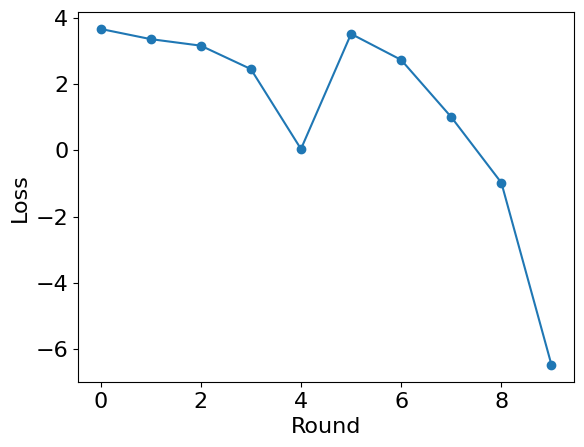

In [7]:
plt.plot(R.inference._summary['best_validation_loss'], marker='o', label=f'{len(R.proposals)}x{R.n_samples}')
plt.xlabel('Round')
plt.ylabel('Loss')

### Plot posterior

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

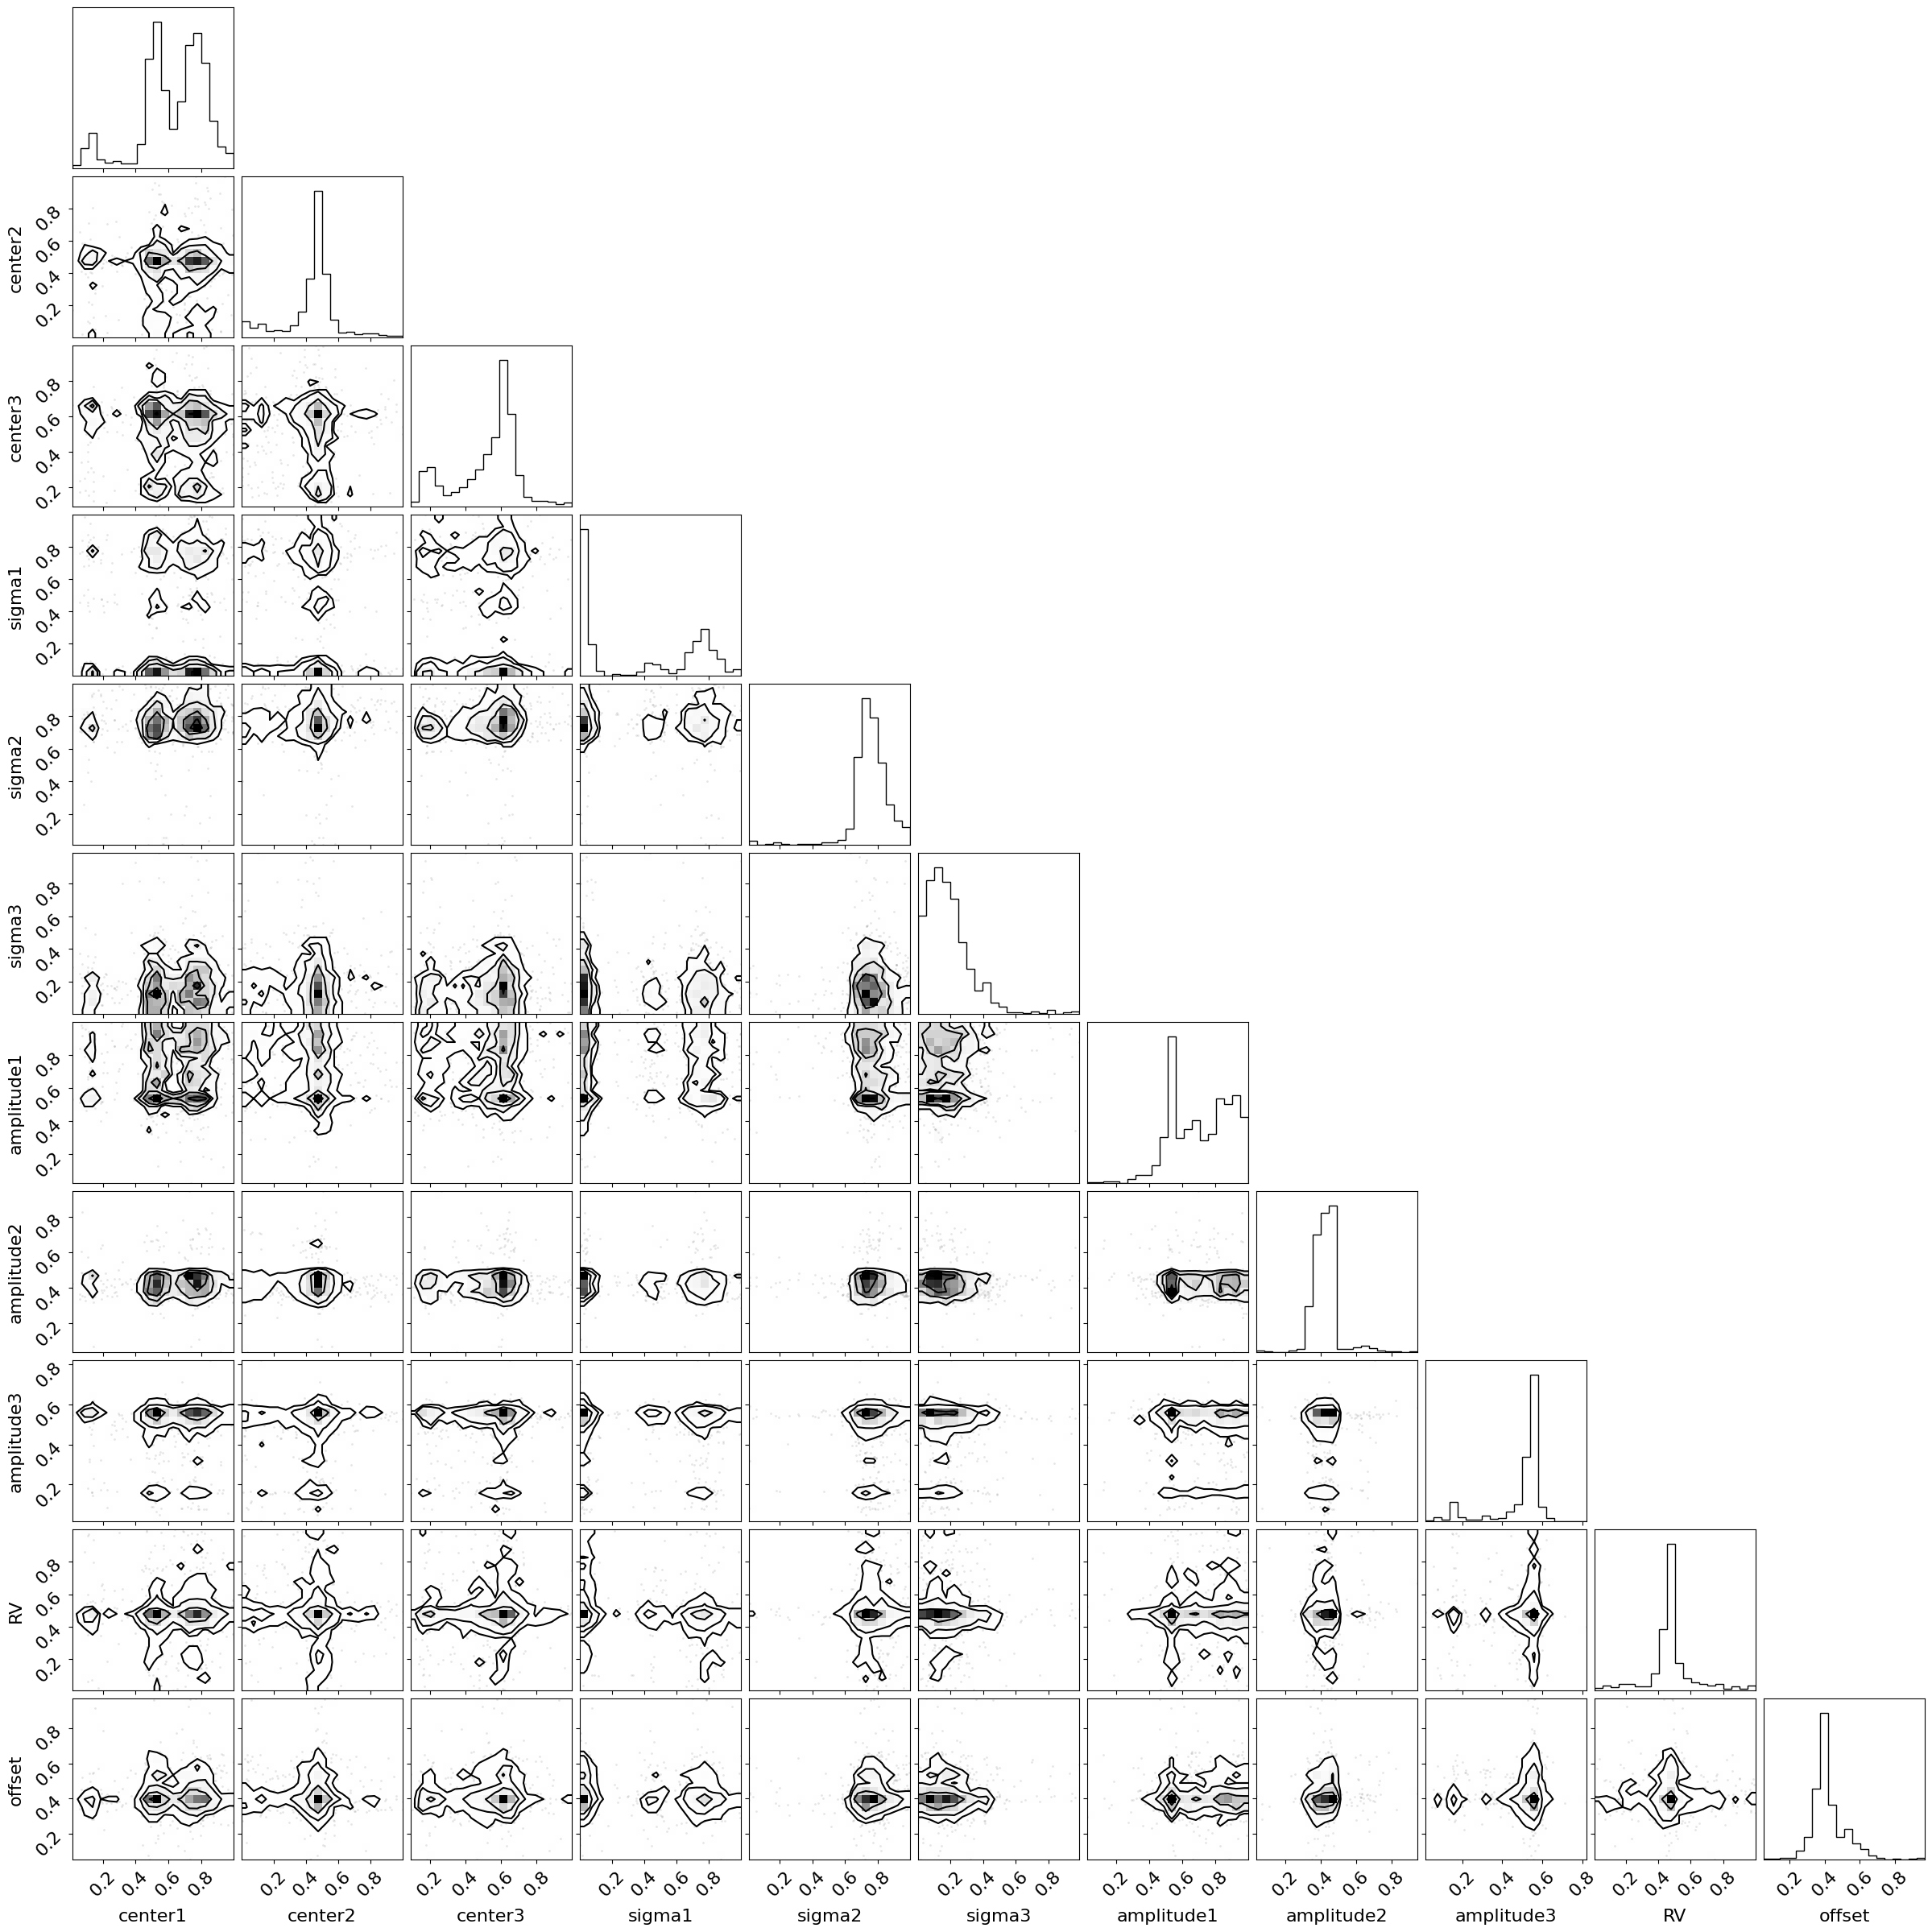

In [9]:
fig=R.plot_corner()

## Posterior diagnostics

### Posterior predictive check

100%|██████████| 100000/100000 [02:15<00:00, 736.63it/s]


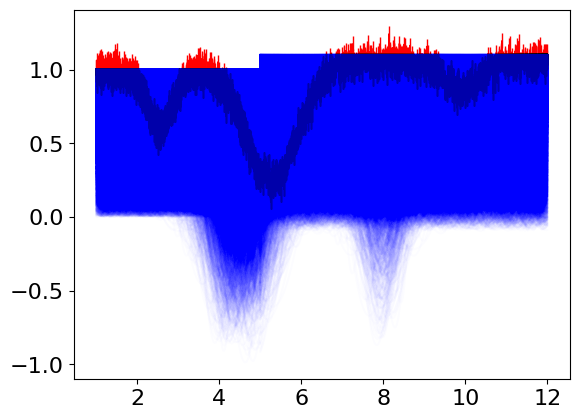

In [ ]:
xs = R.post_x
# Xs=np.concatenate(list(xs.values()), axis=1)

# plt.figure(figsize=)
for key in R.obs.keys():
    plt.errorbar(x=R.obs[key][:,0], y=R.obs[key][:,1], yerr=R.obs[key][:,2], c='r', lw=1, zorder=0)
for i in trange(len(xs[0])):
    for key in R.obs.keys():
        plt.plot(R.obs[key][:,0], xs[key][i], c='b', alpha=0.01, zorder=1)
# plt.xlim(1.5,3.5)
# plt.ylim(0.5,1.05)

In [ ]:
def compute_moments(distribution, num_repeats=10, sample_size=10000):
    """
    Computes the first four per-dimension moments of a multivariate PyTorch distribution,
    along with standard errors from repeated sampling.

    Parameters
    ----------
    distribution : torch.distributions.Distribution
        A PyTorch distribution (must return multivariate samples).
    num_repeats : int
        Number of repetitions to estimate standard error.
    sample_size : int
        Number of samples per repetition.

    Returns
    -------
    moments : dict of numpy arrays
        Dictionary with shape-[D] arrays for each moment/statistic, where D is the number of dimensions:
        - 'mean', 'variance', 'skewness', 'kurtosis'
        - 'mean_error', 'variance_error', 'skewness_error', 'kurtosis_error'
    """
    # Sample once to determine shape
    test_sample = distribution.sample((1,))
    if test_sample.ndim == 1:
        D = test_sample.shape[0]
    else:
        D = test_sample.shape[1]

    # Initialize accumulators
    means = []
    variances = []
    skewnesses = []
    kurtoses = []

    for _ in range(num_repeats):
        samples = distribution.sample((sample_size,))  # [sample_size, D]

        mean = samples.mean(dim=0)
        var = samples.var(dim=0, unbiased=True)
        std = torch.sqrt(var)

        # Standardize
        # centered = (samples - mean) / std
        # skew = (centered ** 3).mean(dim=0)
        # kurt = (centered ** 4).mean(dim=0) - 3  # Excess kurtosis

        means.append(mean.numpy())
        variances.append(var.numpy())
        # skewnesses.append(skew.numpy())
        # kurtoses.append(kurt.numpy())

    # Convert to arrays
    means = np.stack(means)
    variances = np.stack(variances)
    # skewnesses = np.stack(skewnesses)
    # kurtoses = np.stack(kurtoses)

    return {
        'mean': means.mean(axis=0),
        'variance': variances.mean(axis=0),
        # 'skewness': skewnesses.mean(axis=0),
        # 'kurtosis': kurtoses.mean(axis=0),
        'mean_error': means.std(axis=0, ddof=1),
        'variance_error': variances.std(axis=0, ddof=1),
        # 'skewness_error': skewnesses.std(axis=0, ddof=1),
        # 'kurtosis_error': kurtoses.std(axis=0, ddof=1),
    }


In [ ]:
def plot_moment_evolution(distributions, end, compute_moments_fn, R=None, num_repeats=10, sample_size=10000):
    """
    Plot the evolution of moments across training rounds for a list of multivariate distributions,
    with shaded error bars and tightly stacked subplots.

    Parameters
    ----------
    distributions : list of torch.distributions.Distribution
        List of proposal distributions (one per training round).
    compute_moments_fn : function
        Function that returns a dict of per-dimension moment arrays and their errors.
    R : optional
        Object with .parameters (e.g. from sbi) to label dimension names.
    """
    n_rounds = len(distributions)
    moments_all = [compute_moments_fn(d, num_repeats, sample_size) for d in distributions]

    moment_keys = ['mean', 'variance']#, 'skewness', 'kurtosis']
    error_keys = [f"{k}_error" for k in moment_keys]
    n_moments = len(moment_keys)

    # Get dimension names
    if R is not None and hasattr(R, "parameters"):
        param_names = list(R.parameters.keys())
    else:
        param_names = [f"Dim {i}" for i in range(len(moments_all[0]['mean']))]

    n_dims = len(param_names)
    colors = plt.cm.tab10.colors

    # Stack values and errors into arrays of shape [n_rounds, n_dims]
    moment_arrays = {
        k: np.stack([m[k] for m in moments_all], axis=0)
        for k in moment_keys + error_keys
    }

    # Compute differences
    moment_diffs = {
        k: np.abs(np.diff(moment_arrays[k], axis=0))
        for k in moment_keys
    }

    fig, axes = plt.subplots(
        n_moments, 2,
        figsize=(13, 3.0 * n_moments),
        sharex='col',
        gridspec_kw={'hspace': 0, 'wspace': 0.3}  # Tight rows, wider columns
    )

    for i, key in enumerate(moment_keys):
        values = moment_arrays[key]
        errors = moment_arrays[f"{key}_error"]
        diffs = moment_diffs[key]

        for d in range(n_dims):
            color = colors[d % 10]
            axes[i, 0].plot(range(n_rounds), values[:, d], label=param_names[d], color=color)
            axes[i, 0].axvline(end, color='gray', linestyle='--', linewidth=0.8)
            axes[i, 0].fill_between(
                range(n_rounds),
                values[:, d] - errors[:, d],
                values[:, d] + errors[:, d],
                color=color,
                alpha=0.2
            )
            axes[i, 1].semilogy(range(1, n_rounds), diffs[:, d], color=color)

        axes[i, 0].set_ylabel(key.capitalize())
        axes[i, 1].set_ylabel(f"Δ {key}")
        axes[i, 1].axhline(0, color='gray', linestyle='--', linewidth=0.8)

        if i < n_moments - 1:
            axes[i, 0].tick_params(labelbottom=False)
            axes[i, 1].tick_params(labelbottom=False)

    axes[-1, 0].set_xlabel("Training Round")
    axes[-1, 1].set_xlabel("Training Round")

    # Custom manual legend positioning: centered under left column
    handles, labels = axes[-1, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)

    axes[0, 0].set_title("Moment values ± error")
    axes[0, 1].set_title("Differences between rounds")

    plt.subplots_adjust(hspace=0, wspace=0.4, bottom=0.12)  # Give legend room
    plt.show()


Drawing 1 posterior samples: 8032it [00:00, 18296.04it/s]
Drawing 1000 posterior samples: 1099it [00:00, 13364.78it/s]            
Drawing 1000 posterior samples: 1101it [00:00, 13151.62it/s]            
Drawing 1000 posterior samples: 1095it [00:00, 13246.05it/s]            
Drawing 1000 posterior samples: 1099it [00:00, 13331.54it/s]            
Drawing 1000 posterior samples: 1105it [00:00, 13417.36it/s]            
Drawing 1000 posterior samples: 1093it [00:00, 12394.66it/s]            
Drawing 1000 posterior samples: 1082it [00:00, 13802.89it/s]            
Drawing 1000 posterior samples: 1120it [00:00, 13339.64it/s]            
Drawing 1000 posterior samples: 1107it [00:00, 12877.81it/s]            
Drawing 1000 posterior samples: 1080it [00:00, 12755.86it/s]            
Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 66.44it/s]
Drawing 1000 posterior samples: 1083it [00:00, 14180.78it/s]            
Drawing 1000 posterior samples: 1080it [00:00, 15195.43it/s]    

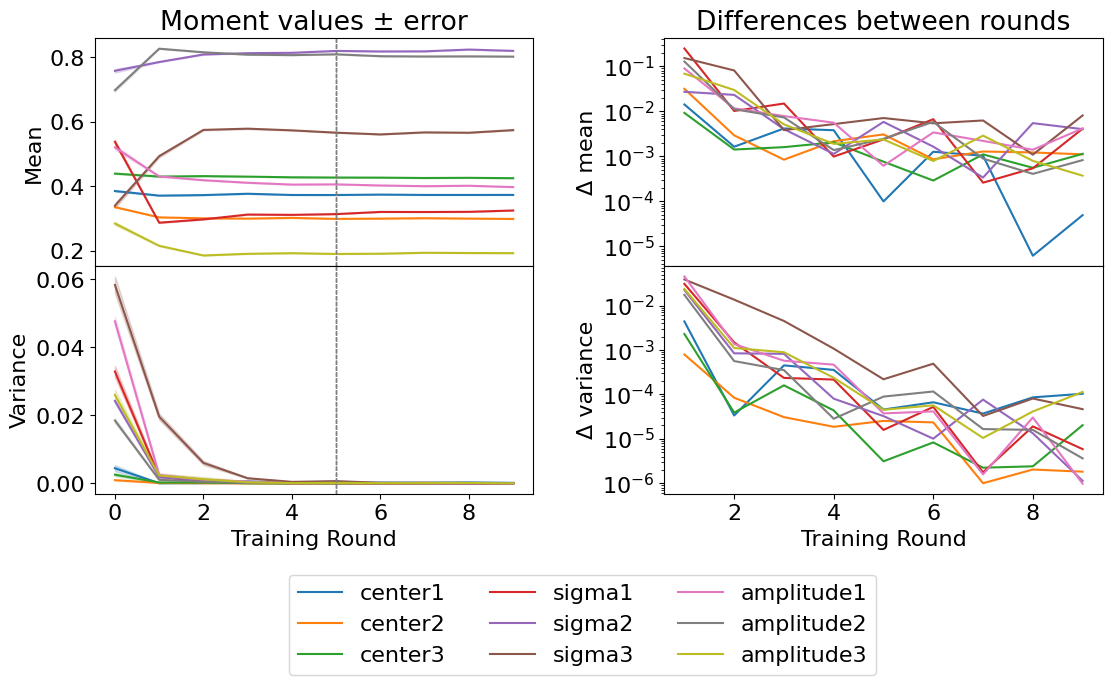

In [ ]:
plot_moment_evolution(R[0].proposals[:], 5, compute_moments, R=R[0], num_repeats=10, sample_size=1000)